<a href="https://colab.research.google.com/github/Gameto2025/Banco_Alura/blob/main/Banco_Alura_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MACHINE LEARNING PARA BANCO ALURA**

###El Banco Alura  quiere anticiparse al problema de abandono de clientes (Churn) y nos ha pedido desarrollar un modelo predictivo, capaz de predecir  qué clientes tienen mayor probabilidad de abandonar el banco.

## **Extraccion y Visualizacion de los datos**

In [ ]:
import warnings

warnings.filterwarnings('ignore')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
try:
    from sklearn2pmml import sklearn2pmml
except ImportError:
    !pip install sklearn2pmml
    from sklearn2pmml import sklearn2pmml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.6 MB/s eta 0:00:00


In [ ]:
datos= pd.read_csv('/content/Banco_Alura.csv')
datos

,RowNumber,CustomerId,Surname,CreditScore,Country,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


## **Calculo de Clases**

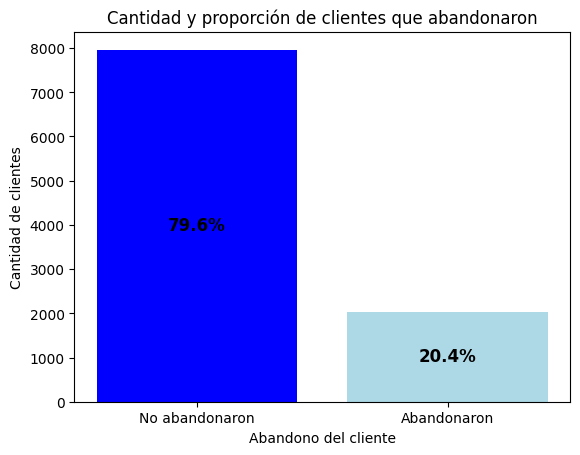

In [ ]:

churn_counts = datos['Churn'].value_counts()
churn_percentages = datos['Churn'].value_counts(normalize=True) * 100

labels = ['No abandonaron', 'Abandonaron']
counts = [churn_counts.get(0, 0), churn_counts.get(1, 0)]
percentages = [churn_percentages.get(0, 0), churn_percentages.get(1, 0)]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=['blue', 'lightblue'])
for bar, percent in zip(bars, percentages):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f'{percent:.1f}%',
        ha='center', va='center', color='black', fontsize=12, fontweight='bold'
    )
ax.set_title('Cantidad y proporción de clientes que abandonaron')
ax.set_ylabel('Cantidad de clientes')
ax.set_xlabel('Abandono del cliente')

plt.show()

En este dataframe existe un desbalance de clases.

## **PREPARACION DE LOS DATOS PARA EL MODELADO**


#### **APLICANDO FEATURE ENGINEERING**

Removiendo columnas

In [ ]:
df= datos.drop(columns=['RowNumber','Tenure', 'CustomerId', 'HasCrCard','EstimatedSalary','Surname'])
df


,CreditScore,Country,Gender,Age,Balance,NumOfProducts,IsActiveMember,Churn
0,619,France,Female,42,0.00,1,1,1
1,608,Spain,Female,41,83807.86,1,1,0
2,502,France,Female,42,159660.80,3,0,1
3,699,France,Female,39,0.00,2,0,0
4,850,Spain,Female,43,125510.82,1,1,0
...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,0.00,2,0,0
9996,516,France,Male,35,57369.61,1,1,0
9997,709,France,Female,36,0.00,1,1,1
9998,772,Germany,Male,42,75075.31,2,0,1



### Creando variables

In [ ]:
df['Balance_zero'] = (datos['Balance'] == 0).astype(int)

df['Mujer_Alemania'] = ((df['Gender'] == 'Female') & (df['Country'] == 'Germany')).astype(int)

df['Inactivo_40_70'] = ((df['Age'] >= 40) & (df['Age'] <= 70) & (df['IsActiveMember'] == 0)).astype(int)

df['Products_Risk_Flag'] = (df['NumOfProducts'] >= 3).astype(int)

df['Country_Risk_Flag'] = (df['Country'] == 'Germany').astype(int)

df['Age_Risk'] = ((df['Age'] >= 40) & (df['Age'] <= 70)).astype(int)

### **Transformando columnas categoricas a numericas**

In [ ]:
df['Country'] = df['Country'].map({
    'Spain': 1,
    'France': 2,
    'Germany': 3
})

In [ ]:
df['Gender'] = df['Gender'].map({
    'Female': 1,
    'Male': 2
})

In [ ]:
df.head(5)

,CreditScore,Country,Gender,Age,Balance,NumOfProducts,IsActiveMember,Churn,Balance_zero,Mujer_Alemania,Inactivo_40_70,Products_Risk_Flag,Country_Risk_Flag,Age_Risk
0,619,2,1,42,0.00,1,1,1,1,0,0,0,0,1
1,608,1,1,41,83807.86,1,1,0,0,0,0,0,0,1
2,502,2,1,42,159660.80,3,0,1,0,0,1,1,0,1
3,699,2,1,39,0.00,2,0,0,1,0,0,0,0,0
4,850,1,1,43,125510.82,1,1,0,0,0,0,0,0,1


### **Usando  mutual_info_classif (Información Mutua)**

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

X = df.drop(columns=['Churn'])
y = df['Churn']

importancias = mutual_info_classif(X, y, discrete_features='auto', random_state=42)

mi_scores = pd.DataFrame({'Variable': X.columns, 'Importancia_MI': importancias})
mi_scores = mi_scores.sort_values(by='Importancia_MI', ascending=False)
print(mi_scores)

              Variable  Importancia_MI
3                  Age        0.071408
5        NumOfProducts        0.068776
12            Age_Risk        0.059971
9       Inactivo_40_70        0.051771
10  Products_Risk_Flag        0.035149
11   Country_Risk_Flag        0.018966
8       Mujer_Alemania        0.017270
1              Country        0.014730
6       IsActiveMember        0.011607
2               Gender        0.011242
4              Balance        0.009895
0          CreditScore        0.009439
7         Balance_zero        0.009418


Se eliminaran las variables que tengan menor indice MI, ya son las que menos aportan en el analisis del churn.

In [ ]:
df_final = df.drop(columns=['Age','CreditScore','Balance_zero','Balance','Gender','IsActiveMember','Mujer_Alemania','Country'])
df_final.sample(10)

,NumOfProducts,Churn,Inactivo_40_70,Products_Risk_Flag,Country_Risk_Flag,Age_Risk
4278,1,0,0,0,1,0
5250,2,0,0,0,1,0
9479,2,0,0,0,0,0
3916,3,0,0,1,0,0
1403,1,0,0,0,0,0
6800,1,0,0,0,0,0
664,2,0,0,0,0,1
9985,2,0,0,0,0,0
3787,1,1,0,0,1,0
4270,2,0,0,0,0,1


### **Verificando Correlacion entre variables**

In [ ]:
df_final.corr().round(4)

,NumOfProducts,Churn,Inactivo_40_70,Products_Risk_Flag,Country_Risk_Flag,Age_Risk
NumOfProducts,1.0000,-0.0478,-0.0297,0.5220,-0.0104,-0.0286
Churn,-0.0478,1.0000,0.3456,0.2986,0.1735,0.3254
Inactivo_40_70,-0.0297,0.3456,1.0000,0.0926,0.0718,0.6019
Products_Risk_Flag,0.5220,0.2986,0.0926,1.0000,0.0496,0.1000
Country_Risk_Flag,-0.0104,0.1735,0.0718,0.0496,1.0000,0.0632
Age_Risk,-0.0286,0.3254,0.6019,0.1000,0.0632,1.0000


Todas las variables elegidas tiene una correlacion moderada que no representan fuga de datos.


####**Aplicando indice VIF para ver si hay colinealidad entre variables**

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_vif = df_final.drop(columns=['Churn'])
X_const = add_constant(X_vif)

vif = pd.DataFrame()
vif["Variable"] = X_const.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif)

             Variable        VIF
0               const  11.432094
1       NumOfProducts   1.391523
2      Inactivo_40_70   1.576249
3  Products_Risk_Flag   1.408808
4   Country_Risk_Flag   1.008865
5            Age_Risk   1.577766


Si el valor es menor a 5 no hay problemas de multicolinealidad. En consecuncia, las variables elegidas no tienen multicolinealidad.

#### **Verificando fuga de datos con Correlacion Pearson**

In [ ]:
corr_target = df_final.corr()['Churn'].sort_values(ascending=False)
print(corr_target)

Churn                 1.000000
Inactivo_40_70        0.345597
Age_Risk              0.325412
Products_Risk_Flag    0.298637
Country_Risk_Flag     0.173488
NumOfProducts        -0.047820
Name: Churn, dtype: float64


En general, ninguna variable tiene alta correlacion (sobre 0.5) con la variable en estudio. Por lo tanto, se podria concluir que no hay fuga de datos.

## **Dataframe final para el modelado**

In [ ]:
df_final.sample(5)

,NumOfProducts,Churn,Inactivo_40_70,Products_Risk_Flag,Country_Risk_Flag,Age_Risk
925,2,0,0,0,1,0
3575,1,0,0,0,0,1
8125,1,0,0,0,1,0
3146,2,1,0,0,0,0
8216,2,0,0,0,1,1


In [ ]:
for col in df_final.columns:
    print(f"\nValores únicos en '{col}':")
    print(df_final[col].unique())



Valores únicos en 'NumOfProducts':
[1 3 2 4]

Valores únicos en 'Churn':
[1 0]

Valores únicos en 'Inactivo_40_70':
[0 1]

Valores únicos en 'Products_Risk_Flag':
[0 1]

Valores únicos en 'Country_Risk_Flag':
[0 1]

Valores únicos en 'Age_Risk':
[1 0]


## **CREANDO BASELINE CON MODELO DUMMY**


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = df_final.drop(['Churn'],axis=1)
y = df_final['Churn']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

dummy_clf = DummyClassifier(strategy='constant', constant=1, random_state=42)
dummy_clf.fit(X_train, y_train)

y_pred = dummy_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud (accuracy) del DummyClassifier: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Exactitud (accuracy) del DummyClassifier: 0.1947
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2416
           1       0.19      1.00      0.33       584

    accuracy                           0.19      3000
   macro avg       0.10      0.50      0.16      3000
weighted avg       0.04      0.19      0.06      3000



# **MODELO XGBOOST**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

Matriz de confusión:
[[1448  145]
 [ 175  232]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1593
           1       0.62      0.57      0.59       407

    accuracy                           0.84      2000
   macro avg       0.75      0.74      0.75      2000
weighted avg       0.84      0.84      0.84      2000

AUC: 0.822


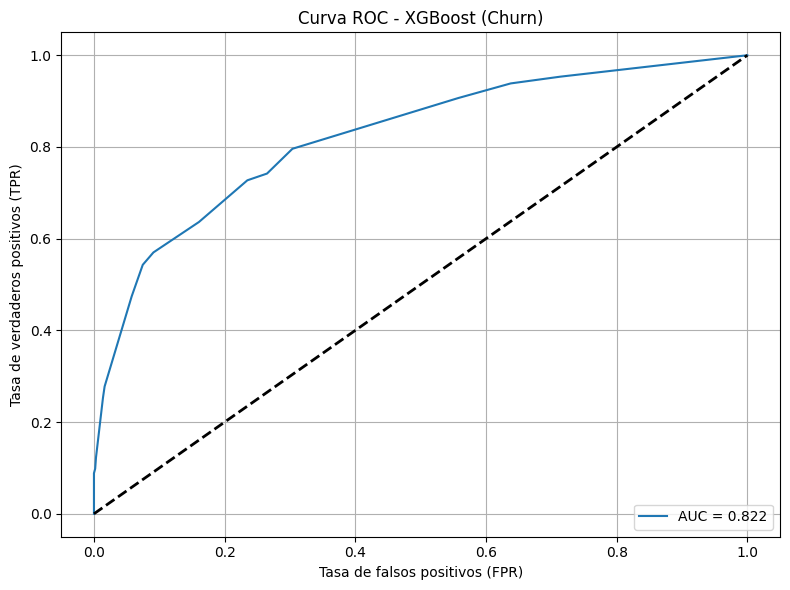

In [ ]:
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

columnas_numericas = [
    'Age_Risk',
    'NumOfProducts',
    'Inactivo_40_70',
    'Products_Risk_Flag',
    'Country_Risk_Flag'
]

# -----------------------------
# Train / Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# -----------------------------
# Preprocesamiento
# -----------------------------
preprocesador = ColumnTransformer(transformers=[
    ('num', 'passthrough', columnas_numericas)
])

# -----------------------------
# XGBoost
# -----------------------------
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# -----------------------------
# Pipeline
# -----------------------------
pipe_xgb = Pipeline(steps=[
    ('preprocesador', preprocesador),
    ('clasificador', XGBClassifier(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric='auc',
        random_state=42,
        n_jobs=-1
    ))
])

# -----------------------------
# Entrenamiento
# -----------------------------
pipe_xgb.fit(X_train, y_train)

# -----------------------------
# Predicciones
# -----------------------------
y_prob = pipe_xgb.predict_proba(X_test)[:, 1]

umbral = 0.58  # mejor umbral
y_pred = (y_prob >= umbral).astype(int)

# -----------------------------
# Evaluación
# -----------------------------
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print(f"AUC: {roc_auc_score(y_test, y_prob):.3f}")

# -----------------------------
# Curva ROC
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - XGBoost (Churn)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## **EVALUACION DEL MODELO CON VARIOS CLIENTES NUEVOS**

In [ ]:
import pandas as pd

# -----------------------------
# Columnas del modelo (orden correcto)
# -----------------------------
columnas_modelo = [
    'Age_Risk',
    'NumOfProducts',
    'Inactivo_40_70',
    'Products_Risk_Flag',
    'Country_Risk_Flag'
]

# Mapeo de países a riesgo
paises_riesgo = {
    0: 0,  # France
    1: 1,  # Germany
    2: 0   # Spain
}

# -----------------------------
# Función para ingresar clientes
# -----------------------------
def ingresar_cliente(n_cliente):
    print(f"\n--- Cliente {n_cliente} ---")

    age = int(input("Edad del cliente: "))
    num_products = int(input("Número de productos contratados: "))

    cuenta_activa = int(input("¿La cuenta está ACTIVA actualmente? (1=Sí, 0=No): "))

    # 🔹 Age_Risk: solo edad
    age_risk = int((age >= 40) and (age <= 70))

    # 🔹 Inactivo_40_70: edad + inactividad
    inactivo_40_70 = int((age >= 40) and (age <= 70) and (cuenta_activa == 0))

    # Riesgo por exceso de productos
    products_risk = int(num_products >= 3)

    print("País:")
    print("0 = France")
    print("1 = Germany")
    print("2 = Spain")
    pais = int(input("Seleccione país: "))
    country_risk = paises_riesgo.get(pais, 0)

    return {
        'Age_Risk': age_risk,
        'NumOfProducts': num_products,
        'Inactivo_40_70': inactivo_40_70,
        'Products_Risk_Flag': products_risk,
        'Country_Risk_Flag': country_risk
    }
# -----------------------------
# Ingreso de múltiples clientes
# -----------------------------
clientes = []
contador = 1

while True:
    clientes.append(ingresar_cliente(contador))
    contador += 1

    continuar = input("\n¿Deseas ingresar otro cliente? (s/n): ").lower()
    if continuar != 's':
        break

# -----------------------------
# DataFrame final
# -----------------------------
clientes_df = pd.DataFrame(clientes)[columnas_modelo]

# -----------------------------
# Predicción con XGBoost
# -----------------------------
probabilidades = pipe_xgb.predict_proba(clientes_df)[:, 1]

umbral_optimo = 0.58  # umbral validado
clientes_df['Prob_Abandono'] = probabilidades
clientes_df['Abandona'] = (probabilidades >= umbral_optimo).astype(int)

# -----------------------------
# Etiquetas claras para interpretación
# -----------------------------
def nivel_riesgo(p):
    if p >= 0.75:
        return 'ALTO'
    elif p >= 0.58:
        return 'MEDIO'
    else:
        return 'BAJO'

clientes_df['Nivel_Riesgo'] = clientes_df['Prob_Abandono'].apply(nivel_riesgo)
clientes_df['Decision'] = clientes_df['Abandona'].map({
    1: 'Abandona',
    0: 'No abandona'
})

# -----------------------------
# Resultados claros
# -----------------------------
print("\n===== RESULTADOS DE PREDICCIÓN =====\n")

for i, fila in clientes_df.iterrows():
    print(
        f"Cliente {i+1}: "
        f"Probabilidad = {fila['Prob_Abandono']:.2%} | "
        f"Riesgo = {fila['Nivel_Riesgo']} | "
        f"Decisión = {fila['Decision']}"
    )

print("\n===== RESUMEN GENERAL =====")
print(clientes_df['Decision'].value_counts())


--- Cliente 1 ---
Edad del cliente: 55
Número de productos contratados: 1
¿La cuenta está ACTIVA actualmente? (1=Sí, 0=No): 1
País:
0 = France
1 = Germany
2 = Spain
Seleccione país: 1

¿Deseas ingresar otro cliente? (s/n): n

===== RESULTADOS DE PREDICCIÓN =====

Cliente 1: Probabilidad = 80.16% | Riesgo = ALTO | Decisión = Abandona

===== RESUMEN GENERAL =====
Decision
Abandona    1
Name: count, dtype: int64


### **CALCULO DEL ODDS RATIO**

El odds ratio es una medida estadística que se usa para comparar la probabilidad relativa de que ocurra un evento entre dos grupos diferentes.

El odds ratio compara los odds de dos grupos, por ejemplo, el grupo expuesto y el grupo no expuesto  a un factor.

             Variable  Coeficiente  Odds_Ratio
3  Products_Risk_Flag     5.707697  301.176547
0            Age_Risk     1.063041    2.895163
2      Inactivo_40_70     1.018862    2.770040
4   Country_Risk_Flag     0.916549    2.500645
1       NumOfProducts    -1.404100    0.245588


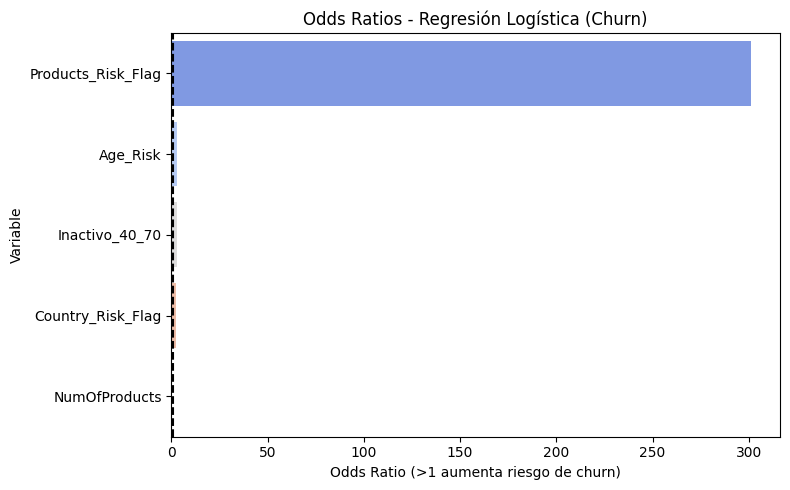

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# -----------------------------
# Variables del modelo
# -----------------------------
X = df_final[
    [
        'Age_Risk',
        'NumOfProducts',
        'Inactivo_40_70',
        'Products_Risk_Flag',
        'Country_Risk_Flag'
    ]
]

y = df_final['Churn']

# -----------------------------
# Train / Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# Pipeline: Logística SIN escalado
# -----------------------------
pipe_log = Pipeline(steps=[
    ('logit', LogisticRegression(
        max_iter=1000,
        solver='liblinear'
    ))
])

pipe_log.fit(X_train, y_train)

# -----------------------------
# Coeficientes y Odds Ratios
# -----------------------------
coeficientes = pipe_log.named_steps['logit'].coef_[0]
odds_ratios = np.exp(coeficientes)

logit_df = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': coeficientes,
    'Odds_Ratio': odds_ratios
}).sort_values(by='Odds_Ratio', ascending=False)

print(logit_df)

# -----------------------------
# Visualización
# -----------------------------
plt.figure(figsize=(8, 5))
sns.barplot(
    data=logit_df,
    x='Odds_Ratio',
    y='Variable',
    palette='coolwarm'
)
plt.axvline(x=1, color='black', linestyle='--')
plt.xlabel('Odds Ratio (>1 aumenta riesgo de churn)')
plt.title('Odds Ratios - Regresión Logística (Churn)')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()


El Churn aumenta fuertemente cuando el cliente tiene demasiados productos, poca actividad y pertenece a países con mayor churn (Alemania). Tener productos ayuda, pero solo hasta cierto punto(maximo 2). El exceso genera el efecto contrario.”

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    pipe_xgb,
    X,
    y,
    cv=5,
    scoring='roc_auc'
)

print(scores, scores.mean())

[0.82712736 0.82546926 0.83106836 0.82233389 0.82239867] 0.825679507859773


AUC ≈ 0.83 → modelo fuerte para churn

Diferencia máx–mín ≈ 0.009 → varianza MUY baja

No hay folds “malos” → no hay overfitting

**“El modelo presenta AUC ≈ 0.83 con baja varianza entre folds.
Se aprueba su paso a producción sin cambios.”**

##**GUARDAR EL MODELO ENTRENADO COMO PKL**

In [ ]:
import joblib

joblib.dump(pipe_xgb, 'modelo_Banco_Alura_churn.pkl')

['modelo_Banco_Alura_churn.pkl']

In [ ]:
!pip install sklearn2pmml

In [ ]:
# Instalación: pip install sklearn2pmml
from sklearn2pmml import sklearn2pmml, PMMLPipeline
from xgboost import XGBClassifier

## **Convirtiendo modelo a PPML para ser leido por Java**

In [ ]:
from sklearn2pmml import sklearn2pmml, PMMLPipeline

# 1. Convertimos tu pipeline actual en un PMMLPipeline
# Esto mantiene el preprocesador y el clasificador intactos
pmml_pipe = PMMLPipeline([
    ("preprocesador", pipe_xgb.named_steps['preprocesador']),
    ("clasificador", pipe_xgb.named_steps['clasificador'])
])

# 2. Exportar a archivo .pmml
try:
    sklearn2pmml(pmml_pipe, "modelo_churn_banco.pmml", with_repr=True)
    print("Archivo 'modelo_churn_banco.pmml' creado con éxito.")
except Exception as e:
    print("Error: Asegúrate de tener instalado Java en tu entorno de Python (necesario para sklearn2pmml).")
    print(f"Detalle: {e}")

Archivo 'modelo_churn_banco.pmml' creado con éxito.
